
<h3 align=center>
Acoustics and coding
</h3>

### General

1. Finish acoustics
1. Example
1. Spectrograms
1. Speech coding

### Acoustics

Here are all the `import` statements we'll need for this notebook:

In [ ]:
%pip install sounddevice

In [ ]:
%pip install pomegranate


In [ ]:
%pip install python_speech_features


In [ ]:
%pip install hmmlearn 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import speechtech as sp
from IPython.display import Audio
import scipy.signal as sig
import pylab
from scipy.io import wavfile
from sklearn import linear_model

We can look at the filtering effect of the vocal tract by recording different vowels we produce and the plotting the spectra:

Chúng ta có thể xem xét hiệu ứng lọc của đường thanh quản bằng cách ghi lại các nguyên âm khác nhau mà chúng ta tạo ra và vẽ biểu đồ quang phổ:

In [ ]:
#fs,w = sp.record()

#a,b = sp.spec(w,fs)
#plt.plot(b[:10000],a[:10000])
#plt.show()

#Audio(w,rate=fs)

### Example

Let's do a schematic example of creating a complex sound. 

Chúng ta hãy cùng làm một ví dụ sơ đồ về cách tạo ra âm thanh phức tạp.

Let's create a complex periodic wave and then concatenate it with a bit of white noise. This is as if we have a vowel *followed* by some fricative.

Hãy tạo ra một sóng tuần hoàn phức tạp rồi nối nó với một chút nhiễu trắng. Điều này giống như chúng ta có một nguyên âm *theo sau* là một âm sát.

In [9]:
#a sine component
w1 = np.sin(np.arange(0,300*np.pi,.1))
#another sine component, higher frequency, lower amplitude
w2 = .5 * np.sin(np.arange(0,600*np.pi,.2))

Audio(w1,rate=len(w1))

In [10]:
Audio(w2,rate=len(w2))

In [11]:
#make sure they have the same lengths!
print(len(w1),len(w2))

9425 9425


In [12]:
#combine the two components
w3 = w1 + w2
#Listen to it
Audio(w3,rate=len(w3))

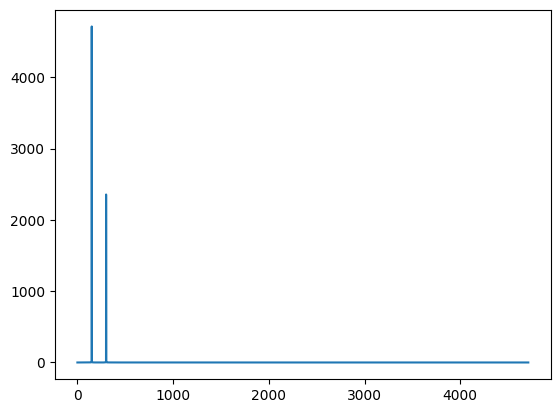

In [13]:
#make sure the spectrum is right!
a,b = sp.spec(w3,len(w3))
plt.plot(b,a)
plt.show()

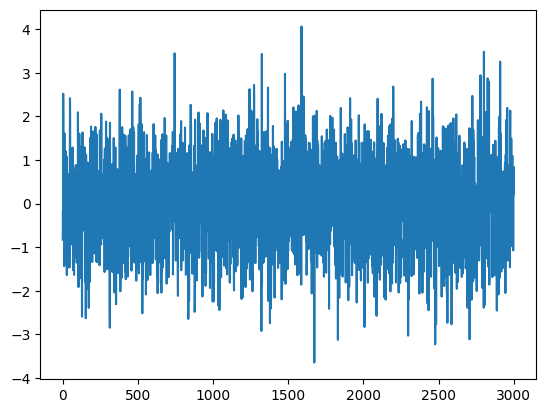

In [14]:
#make some white noise
mean = 0
std = 1 
numsamples = 3000
wn = np.random.normal(mean,std,size=numsamples)

#show it
plt.plot(wn)
plt.show()

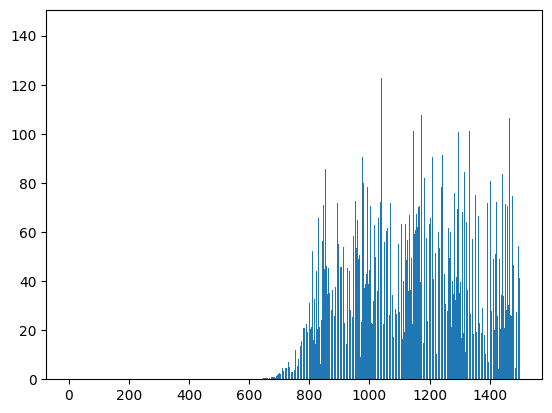

3000


In [15]:
#set nyquist frequency
nyq = numsamples * 0.5

#set filter point
highcut = 800/nyq

#create filter
x,y = sig.butter(8,highcut,btype="highpass")

#apply filter in two passes
z = sig.filtfilt(x,y,wn)

#plot spectrum
a,b = sp.spec(z,numsamples)
plt.bar(b,a)
plt.show()

print(len(z))

Audio(z,rate=5000)

In [16]:
#concatenate
res = np.hstack([w3,z])

#play
Audio(res,rate=6000)

### Spectrograms

Making a spectrogram is easy in praat, but a little more difficult with `python`. First, we load in a wave file:

Tạo một phổ đồ rất dễ dàng trong praat, nhưng hơi khó hơn một chút với `python`. Trước tiên, chúng ta tải vào một file âm thanh:

In [17]:
fs,w = wavfile.read('quick.wav')

Audio(w,rate=fs)

The `pylab` module includes a `specgram()` function. Some of the parameters are a bit mysterious, but here's how to use it.

Mô-đun `pylab` bao gồm hàm `specgram()`. Một số tham số hơi khó hiểu, nhưng sau đây là cách sử dụng.

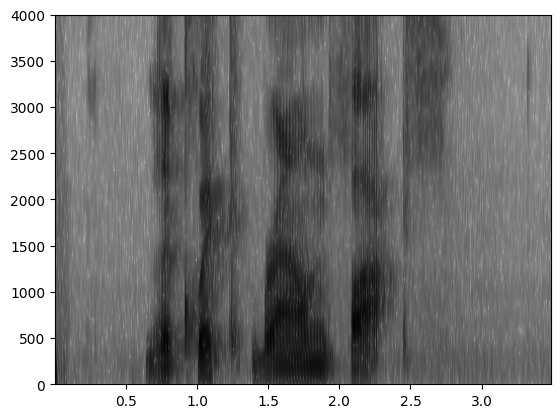

In [18]:
#make the spectrogram
pylab.specgram(
    w,
    Fs=fs,
    NFFT=int(fs*.01),
    cmap='Greys',
    sides='default',
    pad_to=2048
)
#only display up to 8000hz
pylab.axis(ymax=4000)
pylab.show()

### Sampling and quantization

We need to sample at a sufficient rate to detect higher frequencies. Here's a demo. Change the value of `y` to see the effect of sampling.

Chúng ta cần lấy mẫu ở tốc độ đủ để phát hiện tần số cao hơn. Đây là bản demo. Thay đổi giá trị `y` để xem hiệu ứng của việc lấy mẫu.

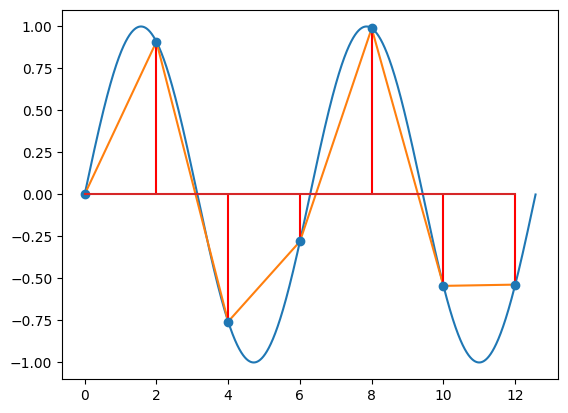

In [19]:
y = 2
x = np.sin(np.arange(0,4*np.pi,y))
z = np.sin(np.arange(0,4*np.pi,.0001))
plt.plot(np.arange(0,4*np.pi,.0001),z)
plt.plot(np.arange(0,4*np.pi,y),x)
plt.stem(np.arange(0,4*np.pi,y),x,'r')
plt.show()

The other problem is *quantization*: how many distinct amplitudes can we distinguish? If we quantize in terms of binary *bits*, we can distinguish amplitudes like this:

Bits | Amplitudes
:---:|:---------:
1    | 2
2    | 4
3    | 8
4    | 16
5    | 32
6    | 64
7    | 128
8    | 256
9    | 512
10   | 1024
11   | 2048

Here's another demo of this. Again, change the value of `y` to see the effect of different quantization choices.

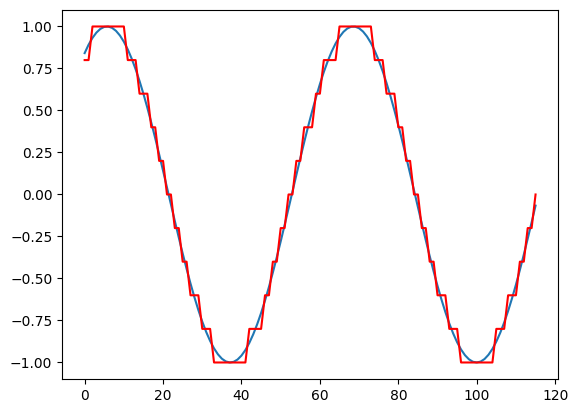

In [20]:
y = 5
x = np.sin(np.arange(1,4*np.pi,.1))
z = y * x
z = z.round()
z = z/y
plt.plot(x)
plt.plot(z,'r')
plt.show()

When we consider efficiency of coding, another interesting possibility to consider is *delta code modulation*. Here's a demo of that:

In [ ]:
x = np.sin(np.arange(0,4*np.pi,.1))
y = x[1:]-x[:-1]
x = x[:-1]
plt.plot(x)
plt.plot(y,'r')
plt.show()

### Linear predictive coding (LPC)

LPC is one simple way of encoding a waveform in a useful and compact way. The basic idea is that we do multiple regression on the wave samples so that we try to predict any particular sample from the $n$ samples that precede it.

Imagine we have a wave $w$ with 100 samples. We can do a third-order LPC on $10$-sample windows. First we break up the wave into $10$-sample windows where this might be the first window:

$$
w_0\ w_1\ w_2\ w_3\ w_4\ w_5\ w_6\ w_7\ w_8\ w_9
$$

We want to predict each number from the three numbers that precede it. This means we have the following equations:

$$
\begin{array}{c}
c_1 w_0 + c_2 w_1 + c_3 w_2 = w_3 \\
c_1 w_1 + c_2 w_2 + c_3 w_3 = w_4 \\
c_1 w_2 + c_2 w_3 + c_3 w_4 = w_5 \\
c_1 w_3 + c_2 w_4 + c_3 w_5 = w_6 \\
c_1 w_4 + c_2 w_5 + c_3 w_6 = w_7 \\
c_1 w_5 + c_2 w_6 + c_3 w_7 = w_8 \\
c_1 w_6 + c_2 w_7 + c_3 w_8 = w_9
\end{array}
$$

What the *autoregression* does is solve for $c_1$, $c_2$, and $c_3$. What it means is that we can represent this window as those coefficients plus the first three values $w_0$, $w_1$, and $w_2$.

Following is a little demo that takes an actual wave and does the same thing. Here, the windows are $30$ samples long and the order of the LPC is $10$.

In [ ]:
fs,w = wavfile.read('quick.wav')

#results go in res
res = np.zeros([len(w)//30,10])
#counters
i = 0
j = 0
#loop for each 30-sample window
while i+30 < len(w):
    #lpc function dies with all 0s
    if all(w[i:i+30] == 0):
        res[j,:] = np.repeat(np.nan,10)
    else:
        res[j,:] = sp.lpc(w[i:i+30],9)
    i += 30
    j += 1

#get a range of color names
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0,1.0,10))

#print each line with a different color
for i in range(10):
    plt.plot(res[:,i],color=colors[i])

#restrict limits
plt.ylim([-50,50])
plt.show()
print(len(w),res.shape)

LPC can then be used in the *opposite* direction, to econstruct a wave. Here's a really simple example where the reconstructed wave is just a sine wave. First, we make the wave and do the 4th-order autoregression.

In [ ]:
x = np.sin(np.arange(0,200*np.pi,.1))
plt.plot(x[:1000])
plt.show()

#build regression data
d = np.zeros([len(x)-4,5])
d[:,0] = x[:-4]
d[:,1] = x[1:-3]
d[:,2] = x[2:-2]
d[:,3] = x[3:-1]
d[:,4] = x[4:]

r = linear_model.LinearRegression()
r.fit(d[:,:4],d[:,4])
r.coef_

In [ ]:
x[0:4]

Then we predict all values starting from the first four:

In [ ]:
#array to store reconstituted wave
y = np.zeros([len(x),1])
#copy first four values
y[:4,0] = x[:4]
#calculate predicted values for all other values
for i in range(4,len(y)):
    y[i,0] = r.predict(y[i-4:i,0].reshape(1, -1))

#display first 1000 values
plt.plot(y[:1000,0])
plt.show()

This is pretty good, but notice that it's not perfect. Here's the sum of the error:

In [ ]:
sum(abs(y[:,0]-x))